In [2]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import time
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import pickle

import tensorflow.keras.backend as K
from utils.model import TBPP384
from utils.prior import PriorUtil
from utils.data import InputGenerator
from utils.training import TBPPFocalLoss
from utils.training import Logger

### Check using devices

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

### Data

In [5]:
from data_utils.cocotext import GTUtility
gt_util = GTUtility('data/COCO-Text', polygon=True)

gt_util_train, gt_util_val = gt_util.split(0.9)

### Data check

In [8]:
idx = 2
_, image, label = gt_util_train.sample()

<IPython.core.display.Javascript object>


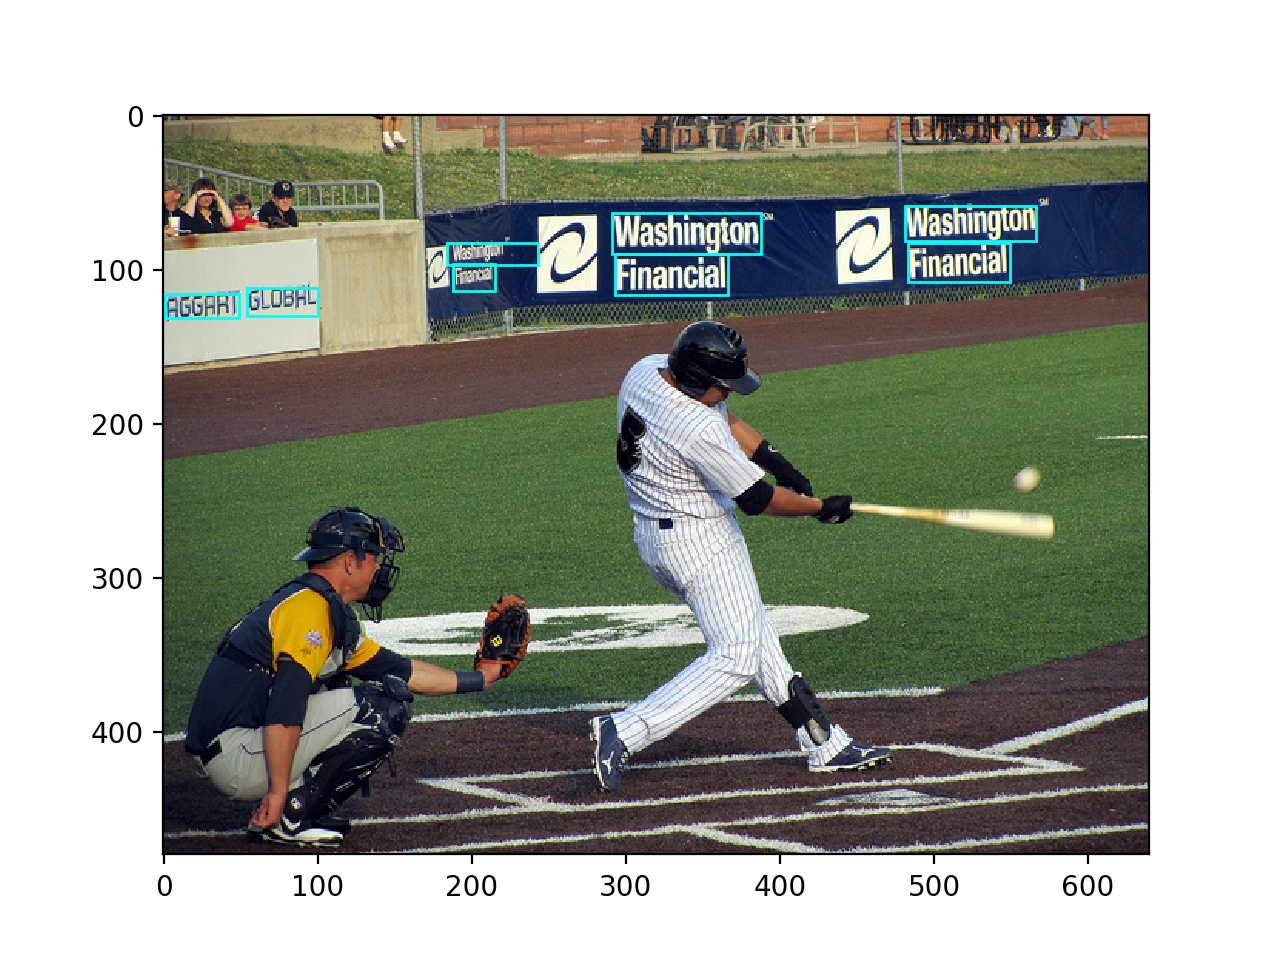

In [9]:
plt.imshow(image)
gt_util_train.plot_gt(label,show_labels=False)
plt.show()

In [110]:
image.shape

(640, 424, 3)

In [109]:
label[:,6] * 600

array([258.16070437, 217.6746726 ])

In [ ]:
plt.imshow(image)
plt.show()

### Model

In [9]:
import glob
import random
import cv2

In [6]:
flist = glob.glob("./data/COCO-Text/train2014/*")

In [7]:
import random

In [8]:
fpath = random.choice(flist)

In [10]:
cv2.imread(fpath).shape

(360, 640, 3)

In [22]:
def ssd384_body(x):
    source_layers = []
    
    # Block 1
    x = Conv2D(64, 3, strides=1, padding='same', name='conv1_1', activation='relu')(x)
    x = Conv2D(64, 3, strides=1, padding='same', name='conv1_2', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same', name='pool1')(x)
    # Block 2
    x = Conv2D(128, 3, strides=1, padding='same', name='conv2_1', activation='relu')(x)
    x = Conv2D(128, 3, strides=1, padding='same', name='conv2_2', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same', name='pool2')(x)
    # Block 3
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_1', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_2', activation='relu')(x)
    x = Conv2D(256, 3, strides=1, padding='same', name='conv3_3', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same', name='pool3')(x)
    # Block 4
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_1', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_2', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv4_3', activation='relu')(x)
    print(f"block 4 : {x.shape}")    
    source_layers.append(x)
    x = MaxPooling2D(pool_size=2, strides=2, padding='same', name='pool4')(x)
    # Block 5
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_1', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_2', activation='relu')(x)
    x = Conv2D(512, 3, strides=1, padding='same', name='conv5_3', activation='relu')(x)
    x = MaxPooling2D(pool_size=3, strides=1, padding='same', name='pool5')(x)
    # FC6
    x = Conv2D(1024, 3, strides=1, dilation_rate=(6, 6), padding='same', name='fc6', activation='relu')(x)
    # FC7
    x = Conv2D(1024, 1, strides=1, padding='same', name='fc7', activation='relu')(x)
    print(f"FC 7 : {x.shape}")    
    source_layers.append(x)
    # Block 6
    x = Conv2D(256, 1, strides=1, padding='same', name='conv6_1', activation='relu')(x)
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(512, 3, strides=2, padding='valid', name='conv6_2', activation='relu')(x)
    print(f"block 6 : {x.shape}")        
    source_layers.append(x)
    # Block 7
    x = Conv2D(128, 1, strides=1, padding='same', name='conv7_1', activation='relu')(x)
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(256, 3, strides=2, padding='valid', name='conv7_2', activation='relu')(x)
    print(f"block 7 : {x.shape}")            
    source_layers.append(x)
    # Block 8
    x = Conv2D(128, 1, strides=1, padding='same', name='conv8_1', activation='relu')(x)
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(256, 3, strides=2, padding='valid', name='conv8_2', activation='relu')(x)
    print(f"block 8 : {x.shape}")                
    source_layers.append(x)
    # Block 9
    x = Conv2D(128, 1, strides=1, padding='same', name='conv9_1', activation='relu')(x)
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(256, 3, strides=2, padding='valid', name='conv9_2', activation='relu')(x)
    print(f"block 9 : {x.shape}")                    
    source_layers.append(x)
    
    return source_layers



In [ ]:
model = ssd384_body(tf.ones((1,512,384,3)))

In [56]:
# TextBoxes++
K.clear_session()
model = TBPP384(input_shape=(512,512,3), softmax=False)
weights_path = './checkpoints/201911120606_tbpp384fl_synthtext/weights.010.h5'
model.load_weights(weights_path)

experiment = 'tbpp384fl_COCOtext'

block 4 : (?, 64, 64, 512)
FC 7 : (?, 32, 32, 1024)
block 6 : (?, 16, 16, 512)
block 7 : (?, 8, 8, 256)
block 8 : (?, 4, 4, 256)
block 9 : (?, 2, 2, 256)


In [26]:
model.input_shape

(None, 512, 512, 3)

In [31]:
source_layers_names = [l.name.split('/')[0] for l in model.source_layers]
map_hs = []
map_ws = []
for i in range(6):
    layer = model.get_layer(source_layers_names[i])
    map_h, map_w = map_size = layer.output_shape[1:3]
    map_hs.append(map_h)
    map_ws.append(map_w)

In [36]:
map_hs

[64, 32, 16, 8, 4, 2]

In [43]:
step_x = 512 / np.array(map_ws)
step_y = 512 / np.array(map_hs)

In [47]:
step_x

array([  8.,  16.,  32.,  64., 128., 256.])

In [52]:
linx = np.array([(0.5 + i) for i in range(2)]) * 256

In [53]:
linx

array([128., 384.])

In [59]:
aspect_ratios = [[1,2,3,5,1/2,1/3,1/5] * 2] * 6

In [63]:
image_size = model.image_size
num_maps = 6

In [65]:
min_dim = np.min(image_size)
min_ratio = 10  # 15
max_ratio = 100  # 90
s = np.linspace(min_ratio, max_ratio, num_maps + 1) * min_dim / 100.
minmax_sizes = [(round(s[i]), round(s[i + 1])) for i in range(len(s) - 1)]

In [82]:
minmax_sizes

[(51.0, 128.0),
 (128.0, 205.0),
 (205.0, 282.0),
 (282.0, 358.0),
 (358.0, 435.0),
 (435.0, 512.0)]

In [83]:
min_size, max_size = minmax_sizes[2]

In [78]:
shift = [None]*6

In [84]:
box_wh = []
box_shift = []
for i in range(len(aspect_ratios)):
    ar = aspect_ratios[i]
    box_wh.append([min_size * np.sqrt(ar), min_size / np.sqrt(ar)])
    box_shift.append(shift[i])
    if ar == 1 and self.special_ssd_box:  # special SSD box
        box_wh.append([np.sqrt(min_size * max_size), np.sqrt(min_size * max_size)])
        box_shift.append((0.0, 0.0))
box_wh = np.asarray(box_wh)

In [85]:
box_wh.shape

(6, 2, 14)

In [87]:
priors_wh = np.tile(box_wh, (2, 1))

In [90]:
priors_wh

array([[[205.        , 289.91378029, 355.07041555, 458.39393539,
         144.95689014, 118.35680518,  91.67878708, 205.        ,
         289.91378029, 355.07041555, 458.39393539, 144.95689014,
         118.35680518,  91.67878708],
        [205.        , 144.95689014, 118.35680518,  91.67878708,
         289.91378029, 355.07041555, 458.39393539, 205.        ,
         144.95689014, 118.35680518,  91.67878708, 289.91378029,
         355.07041555, 458.39393539],
        [205.        , 289.91378029, 355.07041555, 458.39393539,
         144.95689014, 118.35680518,  91.67878708, 205.        ,
         289.91378029, 355.07041555, 458.39393539, 144.95689014,
         118.35680518,  91.67878708],
        [205.        , 144.95689014, 118.35680518,  91.67878708,
         289.91378029, 355.07041555, 458.39393539, 205.        ,
         144.95689014, 118.35680518,  91.67878708, 289.91378029,
         355.07041555, 458.39393539]],

       [[205.        , 289.91378029, 355.07041555, 458.39393539,
 

In [12]:
for layer in model.layers:
    if "_flat" in layer.name:
        print(layer.input.get_shape())

(?, 96, 96, 28)
(?, 48, 48, 28)
(?, 24, 24, 28)
(?, 12, 12, 28)
(?, 6, 6, 28)
(?, 3, 3, 28)
(?, 96, 96, 56)
(?, 48, 48, 56)
(?, 24, 24, 56)
(?, 12, 12, 56)
(?, 6, 6, 56)
(?, 3, 3, 56)
(?, 96, 96, 112)
(?, 48, 48, 112)
(?, 24, 24, 112)
(?, 12, 12, 112)
(?, 6, 6, 112)
(?, 3, 3, 112)
(?, 96, 96, 70)
(?, 48, 48, 70)
(?, 24, 24, 70)
(?, 12, 12, 70)
(?, 6, 6, 70)
(?, 3, 3, 70)


In [91]:
prior_util = PriorUtil(model)

In [163]:
prior_util.priors.shape

(76440, 8)

In [167]:
prior_util.priors_min_xy

array([[ -8.75      , -10.75      ],
       [-14.03122292,  -7.01561146],
       [-18.0836478 ,  -5.36121593],
       ...,
       [307.10213755, 294.20427509],
       [321.21315823, 259.63947468],
       [335.36552149, 204.82760745]])

In [175]:
for i in range(6):
    print(prior_util.prior_maps[i].map_size)

(64, 64)
(32, 32)
(16, 16)
(8, 8)
(4, 4)
(2, 2)


In [176]:
model.inputs

[<tf.Tensor 'input_1:0' shape=(?, 512, 512, 3) dtype=float32>]

In [ ]:
prior_util.

### Saving parameters

In [ ]:
import json

* Add custom Layer

In [ ]:
from tensorflow.keras.utils import get_custom_objects
from utils.layers import Normalize

In [ ]:
get_custom_objects().update({
    "Normalize": Normalize
})

In [ ]:
with open("../model_params.json",'w') as f:
    f.write(model.to_json())

In [ ]:
from tensorflow.keras.models import model_from_json

In [ ]:
with open("../model_params.json",'r') as f:
    parameter_saved_model = model_from_json(f.read())

### Training

In [ ]:
# os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

* checking available batch size of validation set

```
gen_val = InputGenerator(
    gt_util_val, prior_util, batch_size*4, model.image_size)
```python

In [ ]:
from multiprocessing import cpu_count
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
a, b = next(gen_train.generate())

In [ ]:
a.shape

In [ ]:
model.train_on_batch(a,b)

In [ ]:
gen_train.num_batches/4

In [ ]:
images, labels = next(gen_train.generate())

In [ ]:
%matplotlib inline

In [ ]:
images.max()

In [ ]:
plt.imshow((images[0]+100).astype(np.uint8))

In [ ]:
import glob

In [ ]:
fpaths = glob.glob("./data/COCO-Text/train2014/*.jpg")

In [ ]:
import cv2

In [ ]:
cv2.imread(fpaths[0],0).shape

In [ ]:
plt.imshow(cv2.imread(fpaths[0],0))

In [ ]:
epochs = 200
batch_size = 32

gen_train = InputGenerator(gt_util_train, prior_util, batch_size, model.image_size)
gen_val = InputGenerator(gt_util_val, prior_util, batch_size*4, model.image_size)

checkdir = './checkpoints/' + time.strftime('%Y%m%d%H%M') + '_' + experiment
if not os.path.exists(checkdir):
    os.makedirs(checkdir)

with open(checkdir+'/source.py','wb') as f:
    source = ''.join(['# In[%i]\n%s\n\n' % (i, In[i]) for i in range(len(In))])
    f.write(source.encode())

# optim = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9, decay=0, nesterov=True)
optim = tf.keras.optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.0)

# weight decay
regularizer = tf.keras.regularizers.l2(5e-4) # None if disabled
#regularizer = None
for l in model.layers:
    if l.__class__.__name__.startswith('Conv'):
        l.kernel_regularizer = regularizer

loss = TBPPFocalLoss(lambda_conf=10000.0, lambda_offsets=1.0)

model.compile(optimizer=optim, loss=loss.compute, metrics=loss.metrics)

callbacks = [
    ModelCheckpoint(checkdir+'/weights.{epoch:03d}.h5', 
                    verbose=1, save_weights_only=True),
    Logger(checkdir)
]

# print(checkdir.split('/')[-1])
# history = model.fit_generator(
#         gen_train.generate(),
#         epochs=epochs, 
#         steps_per_epoch=int(gen_train.num_batches/4), 
#         callbacks=callbacks,
#         validation_data=gen_val.generate(), 
#         validation_steps=int(gen_val.num_batches/4),
#         workers=cpu_count(), 
#         use_multiprocessing=True)